In [1]:
import configparser
import numpy as np
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import keras.backend as K

from scipy.io import loadmat
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras import optimizers
from utils import get_images_fullpath, load_groundtruth_illuminant
from imaging import srgb_gamma, correct_color_single_image

2022-10-14 01:13:59.932391: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
cfg = configparser.ConfigParser()
cfg.read("./shigehler.cfg")
img_folder_path = cfg["SHIGEHLER"]["DB_PATH"]
gt_file_path = cfg["SHIGEHLER"]["REAL_RGB"]
original_bitdepth = int(cfg["SHIGEHLER"]["ORIGINAL_BITDEPTH"])
npatches_per_image = int(cfg["SHIGEHLER"]["NPATCHES_PER_IMAGE"])

In [3]:
dataset = np.load('./data/shigehler.npz')

patches = dataset['data']
patch_labels = dataset['patch_labels']
image_idx = dataset['image_idx']

In [4]:
print("patches shape: {}".format(patches.shape))
print("patch_labels shape: {}".format(patch_labels.shape))
print("image_idx shape: {}".format(image_idx.shape))

patches shape: (56800, 32, 32, 3)
patch_labels shape: (56800, 3)
image_idx shape: (56800,)


In [6]:
loss = lambda y_true, y_pred: K.sqrt(K.sum(K.square(y_pred - y_true), axis=-1))

In [8]:
def illuminant_model():
    """
    The network consists of 5 layers: 32×32×3 - 32×32×240 - 4×4×240 - 40 - 3
    """
    num_featmaps = 240  # This many filters per conv layer
    w, h = 1, 1         # conv window size
    model = Sequential()
    model.add(Conv2D(num_featmaps, (w, h), padding='same', 
                     kernel_initializer='glorot_uniform', input_shape=patches.shape[1:]))
    model.add(MaxPooling2D(pool_size=(8, 8)))
    model.add(Flatten())
    model.add(Dense(40, kernel_initializer='glorot_uniform', activation='relu')) 
    model.add(Dense(3))
    opt = optimizers.SGD(learning_rate=0.01, momentum=0.9, decay=0.0005)
    model.compile(loss=loss,
                  optimizer=opt, metrics=['mse'])
    return model

In [10]:
model = illuminant_model()
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 32, 32, 240)       960       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 4, 4, 240)        0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 3840)              0         
                                                                 
 dense_2 (Dense)             (None, 40)                153640    
                                                                 
 dense_3 (Dense)             (None, 3)                 123       
                                                                 
Total params: 154,723
Trainable params: 154,723
Non-trainable params: 0
________________________________________________

In [12]:
def compute_angular_error(y_true, y_pred):

    gt_norm = np.linalg.norm(y_true, axis=1)
    gt_normalized = y_true / gt_norm[..., np.newaxis]
    est_norm = np.linalg.norm(y_pred, axis=1)
    est_normalized = y_pred / est_norm[..., np.newaxis]
    dot = np.sum(gt_normalized * est_normalized, axis=1)
    err = np.degrees(np.arccos(dot))
    return err

In [14]:
te_split = loadmat('./data/threefoldCVsplit.mat')['te_split'][0]

npatches = patches.shape[0]
nimages = npatches//npatches_per_image

TOTAL_RUN = 5

cnn_patch_stats = []
cnn_avg_pool_stats = []
cnn_median_pool_stats = []

cnn_patch_ang = np.zeros((npatches, TOTAL_RUN))
cnn_avg_pool_ang = np.zeros((nimages, TOTAL_RUN))
cnn_median_pool_ang = np.zeros((nimages, TOTAL_RUN))

# due to randomness in neural networks, average over TOTAL_RUN runs
for idx_run in range(TOTAL_RUN):

    for idx_fold in range(3): # 3-fold CV

        print("run {} fold {}".format(idx_run+1, idx_fold+1))
        te_idx = te_split[idx_fold][0] - 1 # since Matlab indexes start at 1, we subtract 1
        idx_test = np.in1d(image_idx, te_idx)
        idx_train = ~idx_test
        X_train, y_train = patches[idx_train,...], patch_labels[idx_train,:]
        X_test, y_test = patches[idx_test,...], patch_labels[idx_test,:]

        model = shigehler_model()
        model.fit(X_train, y_train, epochs=8, batch_size=64)
        y_pred = model.predict(X_test)

        # generate a single illuminant estimation per image by pooling
        # the predicted patch illuminants
        for idx, idx_te in enumerate(te_idx):
            this_y_test = y_test[idx*npatches_per_image:(idx+1)*npatches_per_image]
            this_y_pred = y_pred[idx*npatches_per_image:(idx+1)*npatches_per_image]   
            cnn_est_patch_label[idx_te*npatches_per_image:(idx_te+1)*npatches_per_image, :] = this_y_pred
            cnn_est_avg_pool_label[idx_te, :] = np.mean(this_y_pred, axis=0)
            cnn_est_median_pool_label[idx_te, :] = np.median(this_y_pred, axis=0)

            cnn_patch_ang[idx_te*npatches_per_image:(idx_te+1)*npatches_per_image, idx_run] = compute_angular_error(this_y_test, this_y_pred)

        cnn_avg_pool_ang[te_idx, idx_run] = compute_angular_error(y_test[::npatches_per_image,:], cnn_est_avg_pool_label[te_idx, :])
        cnn_median_pool_ang[te_idx, idx_run] = compute_angular_error(y_test[::npatches_per_image,:], cnn_est_median_pool_label[te_idx, :])

run 1 fold 1
Epoch 1/8
593/593 [==============================] - 22s 37ms/step - loss: 0.1221 - mse: 0.0118
Epoch 2/8
593/593 [==============================] - 21s 36ms/step - loss: 0.0917 - mse: 0.0059
Epoch 3/8
593/593 [==============================] - 22s 37ms/step - loss: 0.0880 - mse: 0.0057
Epoch 4/8
593/593 [==============================] - 22s 37ms/step - loss: 0.0860 - mse: 0.0055
Epoch 5/8
593/593 [==============================] - 22s 37ms/step - loss: 0.0848 - mse: 0.0054
Epoch 6/8
593/593 [==============================] - 22s 37ms/step - loss: 0.0838 - mse: 0.0054
Epoch 7/8
593/593 [==============================] - 22s 37ms/step - loss: 0.0829 - mse: 0.0053
Epoch 8/8
591/591 [==============================] - 7s 11ms/step
run 1 fold 2
Epoch 1/8
590/590 [==============================] - 22s 37ms/step - loss: 0.1227 - mse: 0.0129
Epoch 2/8
590/590 [==============================] - 22s 38ms/step - loss: 0.0888 - mse: 0.0055
Epoch 3/8
590/590 [=========================

/var/folders/mm/5611x8r52kb8f3l1ln54rk_h0000gn/T/ipykernel_99227/1976208809.py:8: RuntimeWarning: invalid value encountered in arccos
  err = np.degrees(np.arccos(dot))


run 2 fold 2
Epoch 1/8
590/590 [==============================] - 22s 36ms/step - loss: 0.1226 - mse: 0.0113
Epoch 2/8
590/590 [==============================] - 21s 36ms/step - loss: 0.0904 - mse: 0.0056
Epoch 3/8
590/590 [==============================] - 21s 36ms/step - loss: 0.0870 - mse: 0.0054
Epoch 4/8
590/590 [==============================] - 21s 36ms/step - loss: 0.0854 - mse: 0.0052
Epoch 5/8
590/590 [==============================] - 23s 40ms/step - loss: 0.0837 - mse: 0.0051
Epoch 6/8
590/590 [==============================] - 22s 37ms/step - loss: 0.0830 - mse: 0.0050
Epoch 7/8
590/590 [==============================] - 21s 36ms/step - loss: 0.0819 - mse: 0.0049
Epoch 8/8
597/597 [==============================] - 6s 11ms/step
run 2 fold 3
Epoch 1/8
594/594 [==============================] - 22s 36ms/step - loss: 0.1256 - mse: 0.0129
Epoch 2/8
594/594 [==============================] - 21s 36ms/step - loss: 0.0933 - mse: 0.0062
Epoch 3/8
594/594 [=========================

In [23]:
images = get_images_fullpath(img_folder_path)
images[10:15]

['./data/raw/8D5U5534.png',
 './data/raw/8D5U5535.png',
 './data/raw/8D5U5536.png',
 './data/raw/8D5U5537.png',
 './data/raw/8D5U5538.png']

In [24]:
real_rgb = load_groundtruth_illuminant(gt_file_path)

In [25]:
im_idx = np.random.choice(len(images), 8)
im_idx

array([404,  19, 188, 188,  60,  94, 521, 519])

In [26]:
input_imgs = []
gt_imgs = []
cnn_imgs = []

for idx in im_idx:
    img = cv2.imread(images[idx], cv2.IMREAD_UNCHANGED).astype(np.float64)
    img = img[:,:,::-1] # convert BGR to RGB
    img = cv2.resize(img, (512, 512))
    # subtract black level: For the Canon 5D the black level is 129 and
    # for the Canon 1D it is zero.
    if "canon5d" in images[idx]:
        img = np.maximum(img - 129, 0)
    gt_img = correct_color_single_image(img, real_rgb[idx, :])
    cnn_img = correct_color_single_image(img, cnn_est_avg_pool_label[idx, :])

    img = img / (2**original_bitdepth -1)
    img = srgb_gamma(img)
    input_imgs.append(img)

    gt_img = gt_img / (2**original_bitdepth -1)
    gt_img = srgb_gamma(gt_img)
    gt_imgs.append(gt_img)

    cnn_img = cnn_img / (2**original_bitdepth -1)
    cnn_img = srgb_gamma(cnn_img)
    cnn_imgs.append(cnn_img)

input_imgs = np.concatenate(input_imgs, axis=1)
gt_imgs = np.concatenate(gt_imgs, axis=1)
cnn_imgs = np.concatenate(cnn_imgs, axis=1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'CNN corrected images')

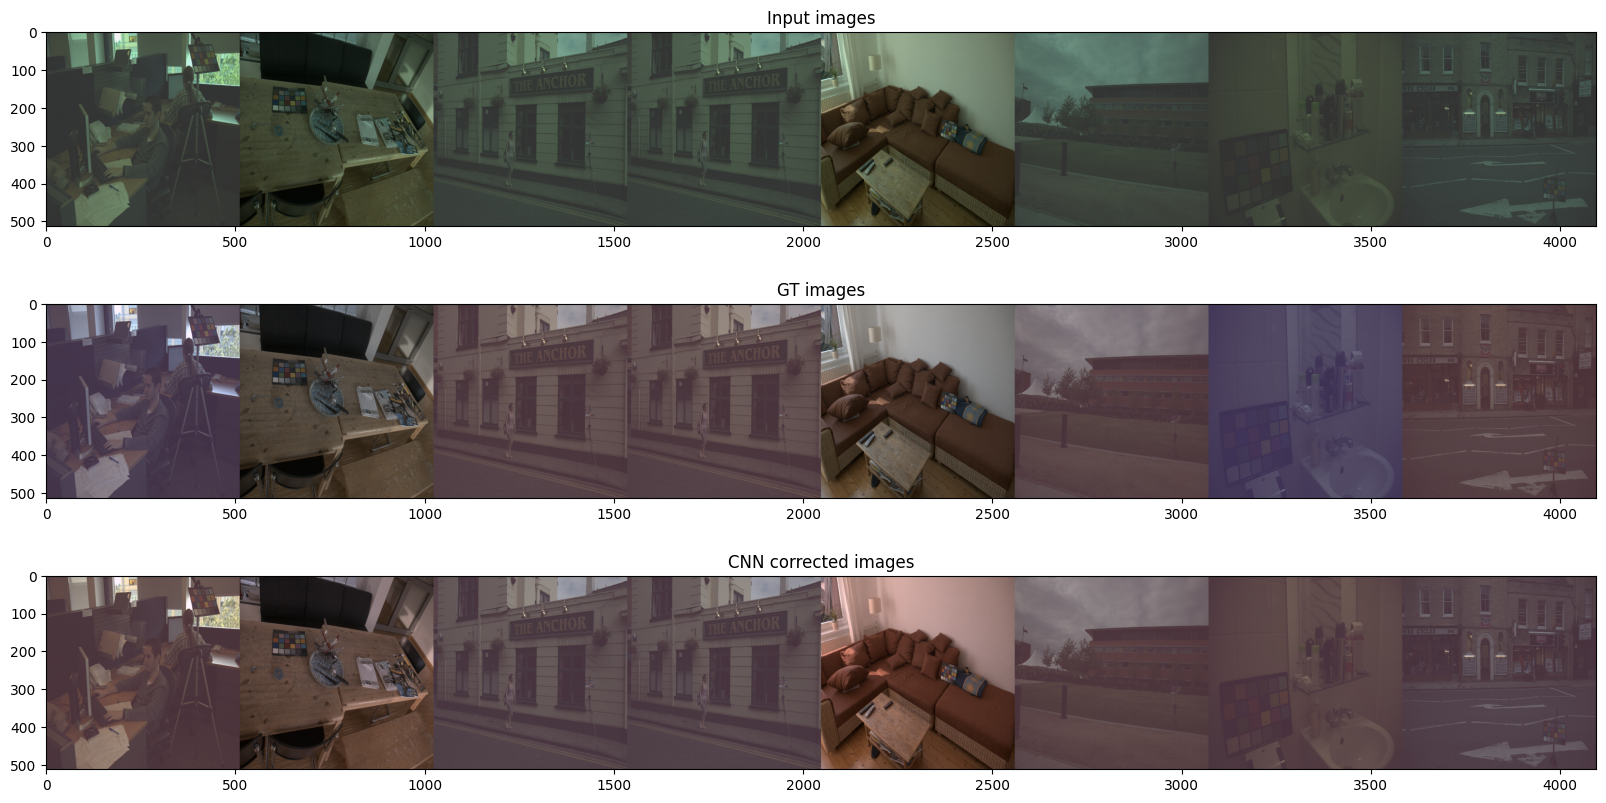

In [27]:
fig, ax = plt.subplots(3, 1, figsize=(20, 10))
ax[0].imshow(input_imgs)
ax[0].set_title('Input images')
ax[1].imshow(gt_imgs)
ax[1].set_title('GT images')
ax[2].imshow(cnn_imgs)
ax[2].set_title('CNN corrected images')